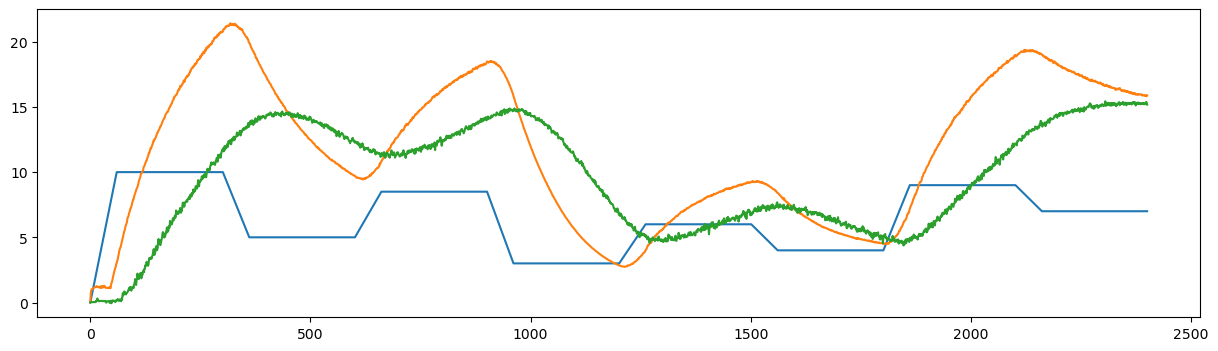

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("..")

from structureSelector import *
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))) * 100, 3)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))),'\nMSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

dataTank = pd.read_csv('../data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,-1))
y = np.array(dataTank[['tank1', 'tank2']].T)

plt.figure(figsize=(15,4))
plt.plot(u.T)
plt.plot(y.T)
plt.show()

[Y2.1 Y2.2 Y1.1 Y1.2 U1.2] [ 0.65694291  0.33397516  0.0574249  -0.04870856 -0.00104841]
-0.00104841348835423*U1.2 + 0.0574248975450331*Y1.1 - 0.0487085566436631*Y1.2 + 0.656942908615915*Y2.1 + 0.333975160203195*Y2.2
Simulação livre
1 [0]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4]

Simulação livre
RMSE: 0.33878503918872505 
MSE: 0.11477530277810598 
AET: 658.5193702912167 
MAPE: 4.538%

Um passo a frente
RMSE: 0.1325874191688393 
MSE: 0.01757942372185349 
AET: 247.27216499374433 
MAPE: 2.738%


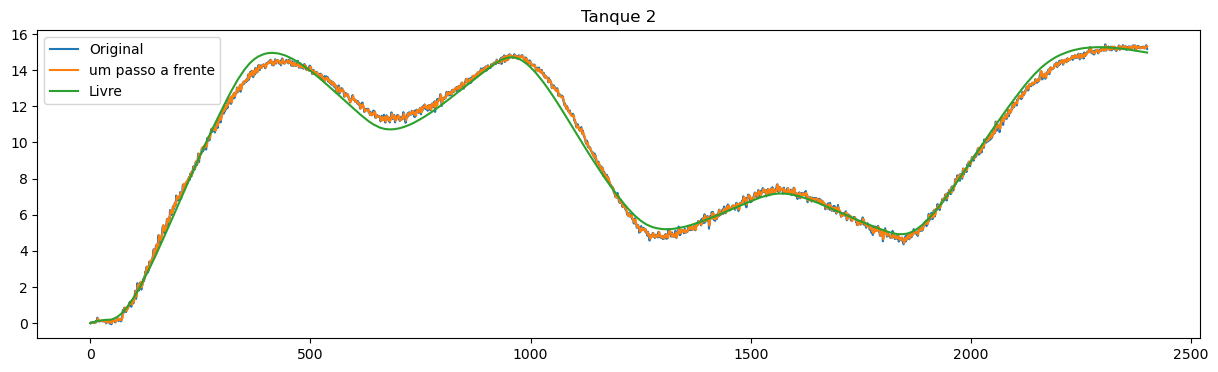

In [2]:
#Selecione o tanque 
output = 1  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8, 'diff':False})
params.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.0000001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

print(model @ theta)

#print(ss)

slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1)

print("\nSimulação livre")
metrics(y[output], slivre)
print("\nUm passo a frente")
metrics(y[output], yhat)

plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(y[output].T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.legend()
plt.show()

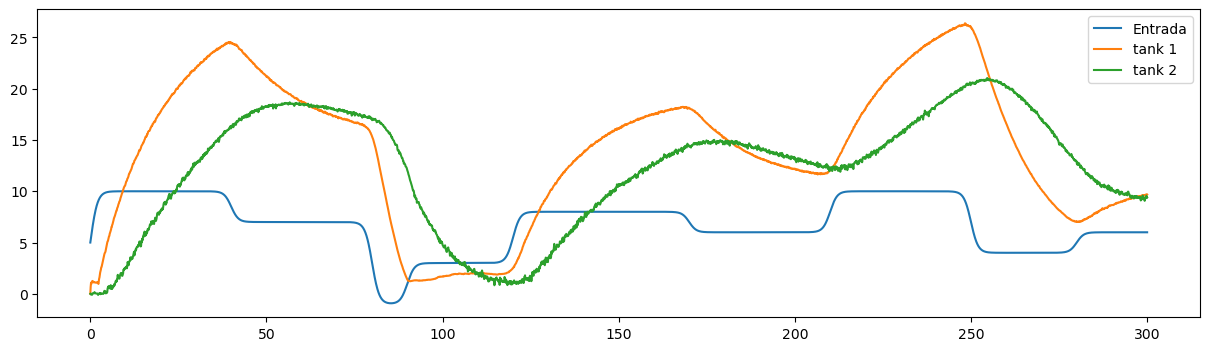

In [3]:
## Validação
mat_content1 = sc.loadmat("../data/ct1x1.mat")
mat_content2 = sc.loadmat("../data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('../data/xinput.csv')
t = input['t']
uVal = np.array(input['v']).reshape((1,-1))

plt.figure(figsize=(15,4))
plt.plot(t, uVal.T, label='Entrada')
plt.plot(t1, v1, label="tank 1")
plt.plot(t2, v2, label="tank 2")
plt.legend()
plt.show()


(2, 3001)
Simulação livre
1 [0]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4]
Modelo selecionado:
-0.00104841348835423⋅U1.2 + 0.0574248975450331⋅Y1.1 - 0.0487085566436631⋅Y1.2 
+ 0.656942908615915⋅Y2.1 + 0.333975160203195⋅Y2.2


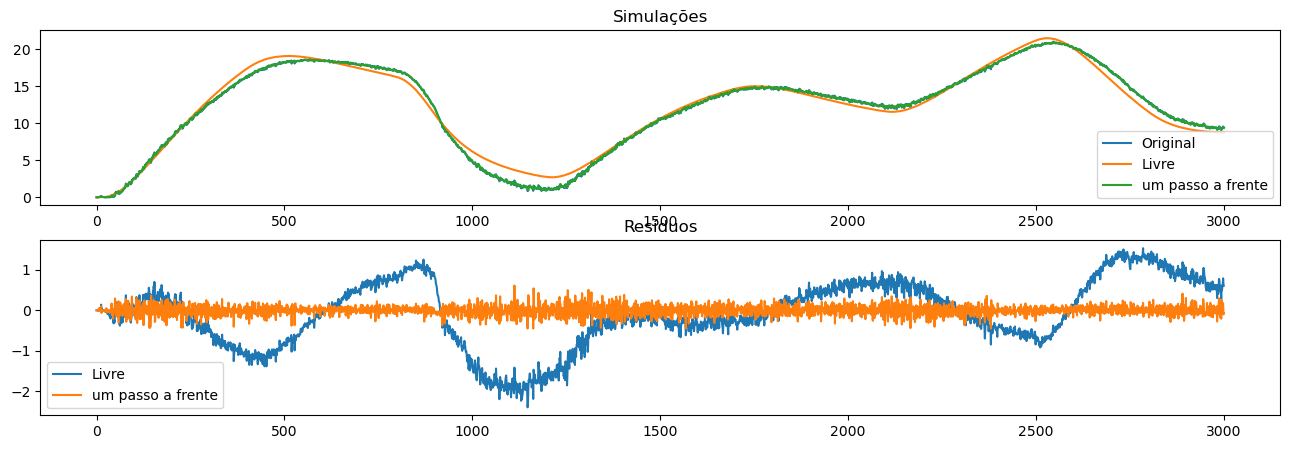


Simulação livre
RMSE: 0.8007266309675803 
MSE: 0.6411631375406917 
AET: 1919.9300393690125 
MAPE: 9.977%

Um passo a frente
RMSE: 0.12389926045283135 
MSE: 0.015351026740758538 
AET: 281.9265009792311 
MAPE: 2.871%


In [4]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
#v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2,1, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[output].T, valLivre)
print("\nUm passo a frente")
metrics(yVal[output].T, yhat)